# Google　Colab上のRで遺伝子発現解析
遺伝子発現を全遺伝子で調べられるマイクロアレイデータを例に、遺伝子発現データをR言語で処理してみて、発現に差のある遺伝子をピックアップし、（外部のエンリッチメント解析ウェブサービスを利用して）生物学的に解釈するというのをやってみた。
（あくまでRの勉強用なので、一部 簡略化しているところがある）
（参考までに同じことをRStudioでやった版や、Excelでやった「Excelでなぞる遺伝子発現解析」もあります）

## Google Colaboratoryでの利用について
このファイルを自分のGoogle　Colaboratory （Google Colab） で開くと編集なりができるようになるはずです。作ったファイルは自分のGoogle　Driveに保存されます。
右上にGoogleアカウントのアイコンが出ているはずです。（私も含めて）複数のGoogleアカウントを持っていると、えてして別のアカウントでGoogle　Colabが開かれたりしていまいますので、保存されるファイルもそのアカウントのGoogle　Driveに保存されます。ファイルを行方不明にしないように。。。

## 背景
### 今回 利用するデータ
- GSE15515 ：Transcriptome Profiles of Differentiated arabidopsis Leaf Cells and Dedifferentiating Protoplasts of Ler and kyp mutant （シロイヌナズナ Ler および kyp 変異体における分化した葉細胞と脱分化したプロトプラストでのトランスクリプトーム [全遺伝子発現] プロファイル） https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE15515
- 今回はこれを加工したデータを用いる ([GSE15515.for_lecture.tsv](https://raw.githubusercontent.com/chalkless/lecture/master/biostats/exp/GSE15515.for_lecture.tsv))。あらかじめダウンロードしておく。（右クリックして「名前をつけて保存」）


### 生物学的背景
- 多細胞生物は、受精卵から細胞分裂して、人間であれば血球、神経、皮膚などなどさまざまな細胞に特化していく。この特化のことを分化という。
分化は不可逆的で、動物の場合は一般的には血球や皮膚などに分化した細胞から、未分化状態には戻れない。（植物の場合は、薬品処理をしたりするなどすると戻れる）
- 今回は分化した葉の細胞と、未分化状態に戻したプロトプラスト（薬品処理して細胞壁を破壊し、未分化状態に戻した）で遺伝子の発現状況を比較して、葉の状態のみ、プロトプラストの状態のみで発現している（＝働く）遺伝子はどういう機能があるのか、というのを確認する。
- （はしょって言えば）これのヒト版が京大・山中先生がノーベル賞をとったiPS細胞の話（成熟した細胞の多能性を持つ細胞への初期化）である（今回のと同様に解析したければ、元データは https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE18226 からダウンロードできる。が、次に述べる加工は必要）

### 解析の目標
- Arabidopsis（シロイヌナズナ）の葉とプロトプラスト（細胞壁を薬品的に除去した状態）でどんな機能の遺伝子が特異的に（=その状態のみで）働いているか?（または働いていないか?）


## 遺伝子発現データの統計的な解析

### ファイルを開く
* まずこのファイルをGoogle　Colabで見られるようにするのが第一歩です。。。
* 改めてだが、今回はGEOから取得したデータを加工した ([GSE15515.for_lecture.tsv](https://raw.githubusercontent.com/chalkless/lecture/master/biostats/exp/GSE15515.for_lecture.tsv)を使って説明する。（ので右クリックでダウンロードしておく。拡張子がtxtファイルのファイルの場合もあるのであとで呼び出す際にファイル名を合わせて変更すること）
* データをアップロードする。
* 画面左のフォルダマークをクリックすると、ファイルの一覧が表示されるので、そこに自分のマシンからファイルをドラッグアンドドロップするか、ファイルと書かれた次の行の一番左（紙に↑マーク。マウスオーバーするとセッションストレージにアップロードと出る）をクリックしてファイルを選択し、データのファイルをこのファイルから見えるようにする。
*　その際、ランタイムが切れた時にファイルも消えてしまう旨、表示が出るがしかたないのであきらめる。
* 実際、しばらくアクセスしないとファイルが消えてしまうので、つどつどアップする。
*　Google　Driveを見えるようにすればいいのだが、その方法はここではややこしいので扱わない。詳しくは[Google ColabでRを使いDriveにアクセスする](https://mana.bi/wiki.cgi?page=Google+Colab%A4%C7R%A4%F2%BB%C8%A4%A4Drive%A4%CB%A5%A2%A5%AF%A5%BB%A5%B9%A4%B9%A4%EB)

* データの方は、今回はタブ区切り（tsv: tab separated value）ファイル。
*　次のようにして読み込む
  *  file_use　でファイル名を記載（今回はtxtとtsvと名前違いで配布しているため、自分のファイルに合わせて書き換えること）
  * read.table関数でfile_useを読み込む。ヘッダがあるとか、データに対するラベルがついているかどうかの指定もしている
  * Windowsでいうところのメモ帳で開くような（専門的にはエディターと呼ばれるソフトで開くような。人間の読める）ファイルをテキストファイルというが、Rで扱うようなファイルにはタブ区切りの他にCSVファイル（カンマ区切り：comma separated value）がある。その場合、sep（区切り文字）を\tでなく , にするか、read.tableでなくread.csvを用いる。
  * header は、1行目に列ラベルがついているかどうか。ついていればTRUE、ついていなければFALSE
  * row.names = 1: 1列目をデータでなく、行の名前として用いる（これを指定しないと、Rが勝手に1から行の名前を振っていって、この場合、プローブIDもデータとして扱われる）



In [2]:
file_use <- "GSE15515.for_lecture.tsv"
data <- read.table(file_use, header = TRUE, row.names = 1, sep = "\t")


再生ボタンを押すなり、⌘+Enter（Mac）、Ctrl+Enter (Win)
すると実行されるが、特に何も起きない。
実際にデータが読み込まれたか、データの頭の方をちょっと見てみる。

In [3]:
head(data)

,leaf1,leaf2,protoplast1,protoplast2
,<dbl>,<dbl>,<dbl>,<dbl>
244901_at,11.91535,9.195704,119.11572,94.60929
244902_at,26.50220,22.453057,93.52045,87.11625
244903_at,16.06390,11.471006,131.40715,107.20512
244904_at,29.37771,38.451554,85.46193,79.22534
244905_at,12.15569,10.373854,10.88078,12.06227
244906_at,18.39766,12.265720,324.64969,274.39683


* 今回はID_REF（プローブ名）, leaf1, leaf2, protoplast1, protoplast2 というデータ構成になっている。

### データの分布を調べてみる
- データの列には遺伝子の発現量が数値で入っている
  - GEOに登録してあるのは対数値なのですが、行に対して計算をする（今回は対数をとる）演習と、あとで平均をとるので今回はわざわざ数値を元に戻しています（なので、先ほどGEOからとってきたファイルと中身が違います）
- ちらちら眺めると0に近い値から数千まで数値があるような
- そこで、各列で最大値を計算してみましょう。
  - 今回の場合、各列について計算をしてみます

In [4]:
max(data$leaf1)
max(data$leaf2)
max(data$protoplast1)
max(data$protoplast2)

[1] 17368.67

[1] 18021.11

[1] 16520.85

[1] 17506.46

- このように各列全体をさすには「データ名$列名」のようにします。
- 同様にして最小値（min）、平均値（mean）、中央値（median）も計算すれば良いのですが、Rの場合、表全体に対してまとめて各列の統計を出す関数が用意されているのでそれを使いましょう。

In [5]:
summary(data)

     leaf1              leaf2            protoplast1         protoplast2       
 Min.   :    5.29   Min.   :    5.489   Min.   :    5.848   Min.   :    5.935  
 1st Qu.:   13.22   1st Qu.:   13.060   1st Qu.:   12.733   1st Qu.:   12.917  
 Median :   43.34   Median :   41.812   Median :   38.968   Median :   37.544  
 Mean   :  278.32   Mean   :  278.575   Mean   :  279.657   Mean   :  282.623  
 3rd Qu.:  199.83   3rd Qu.:  192.416   3rd Qu.:  209.694   3rd Qu.:  207.927  
 Max.   :17368.67   Max.   :18021.107   Max.   :16520.847   Max.   :17506.463  

- 暫定的な考察：左2列がleaf、右2列がprotoplast。これからその2列どうしの数値の平均をとるが、特に中央値や平均値が大きくずれていないので、2列のデータの分布はほぼ同じそうだと期待でき、特に補正（正規化という）をせずに先に進むこととする。（というか実際はすでに補正済のデータが登録されていたのだろう）
- Rの場合、本当にずれていないかどうかをすぐに可視化できるので、leaf1/leaf2の各分布（ヒストグラム）、leaf1 vs leaf2とleaf1 vs protoplast1の散布図を描いて確認してみましょう。
* 見やすくするためにヒストグラムをとる時に対数をとっています。

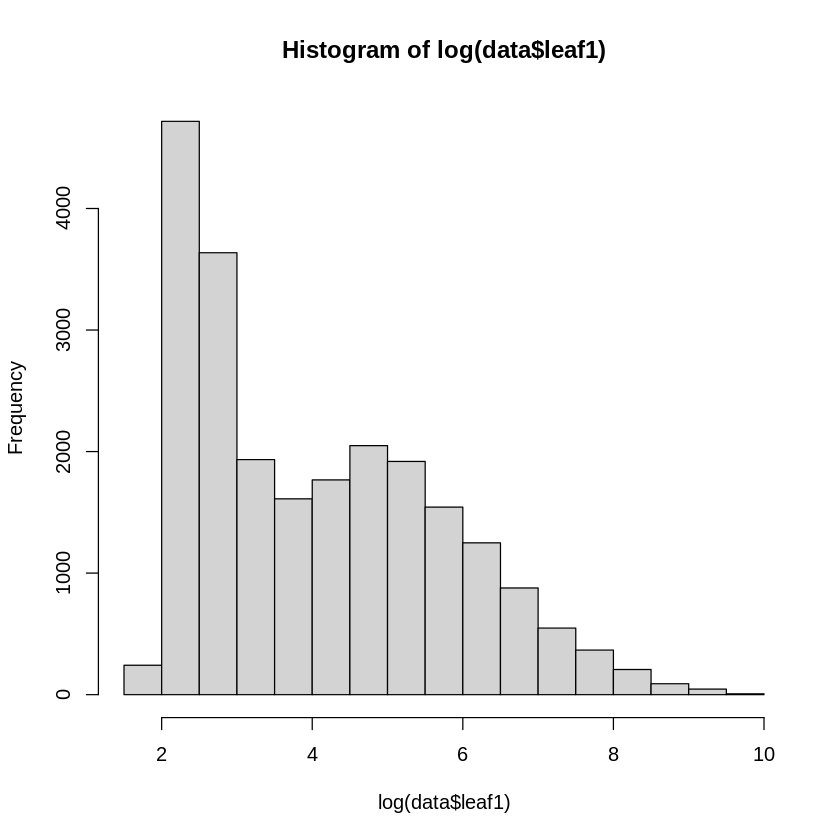

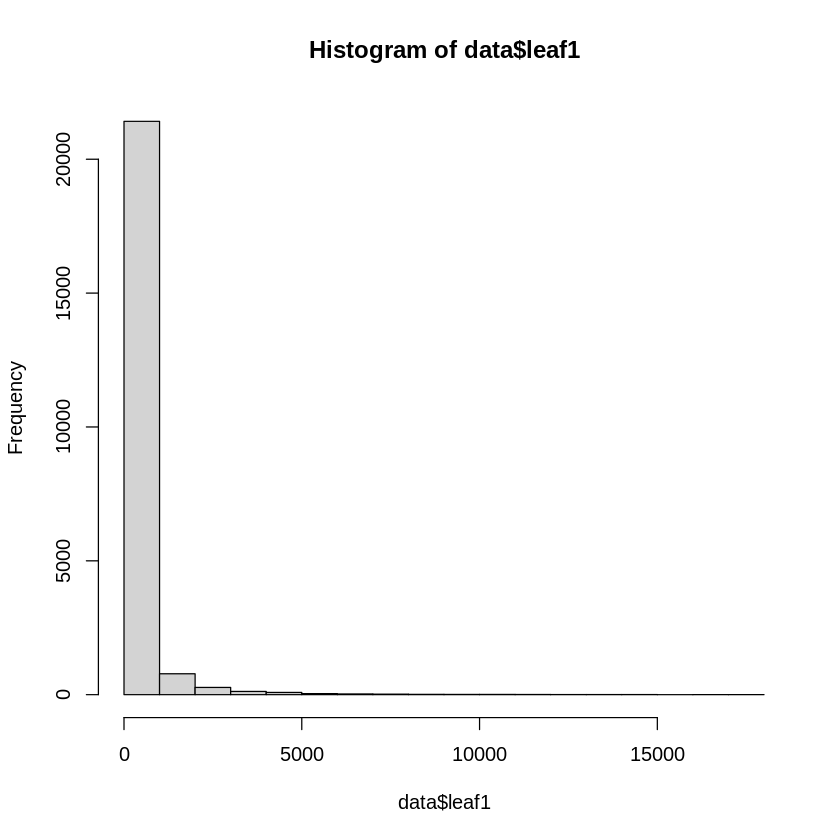

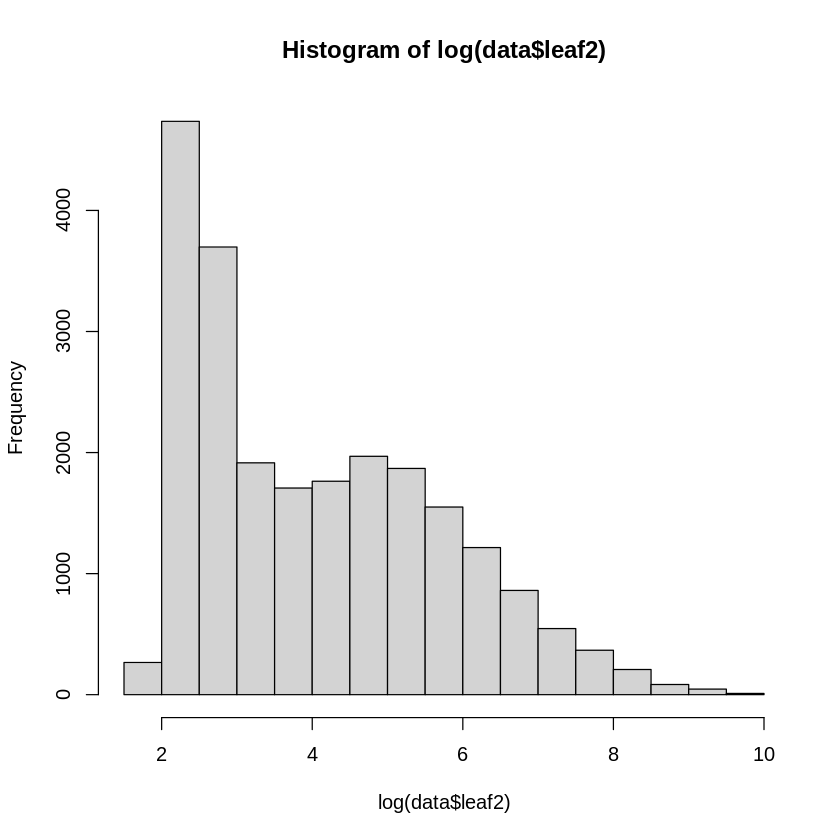

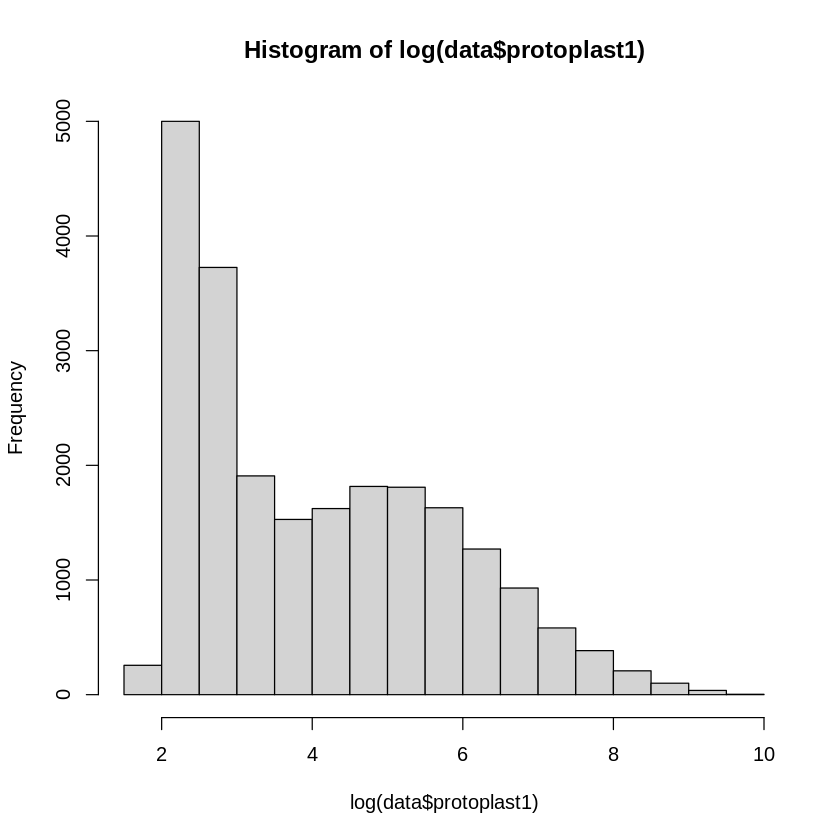

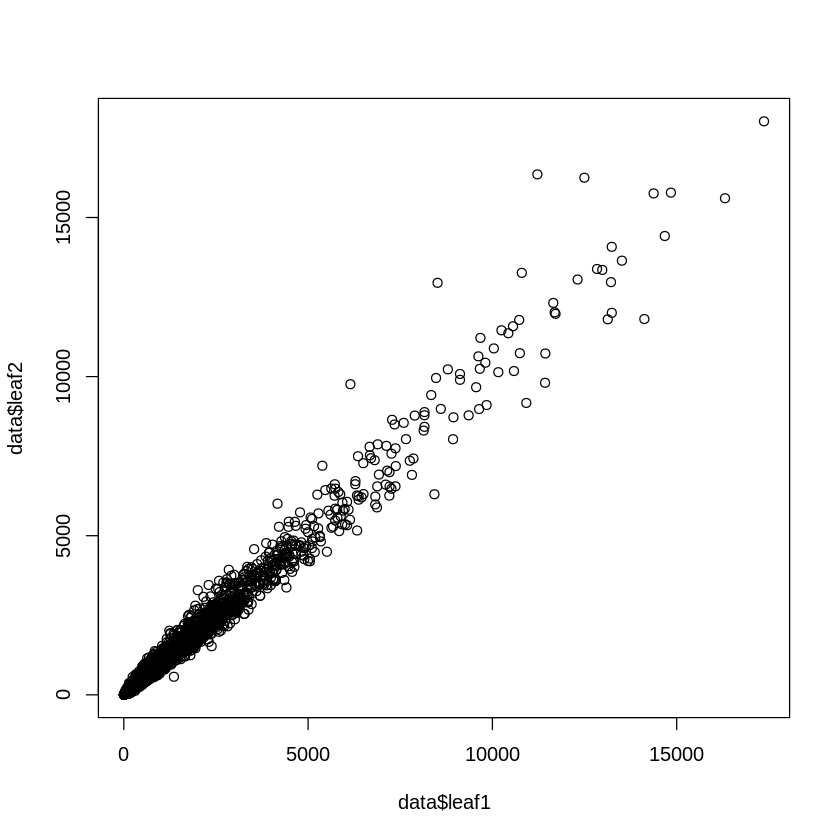

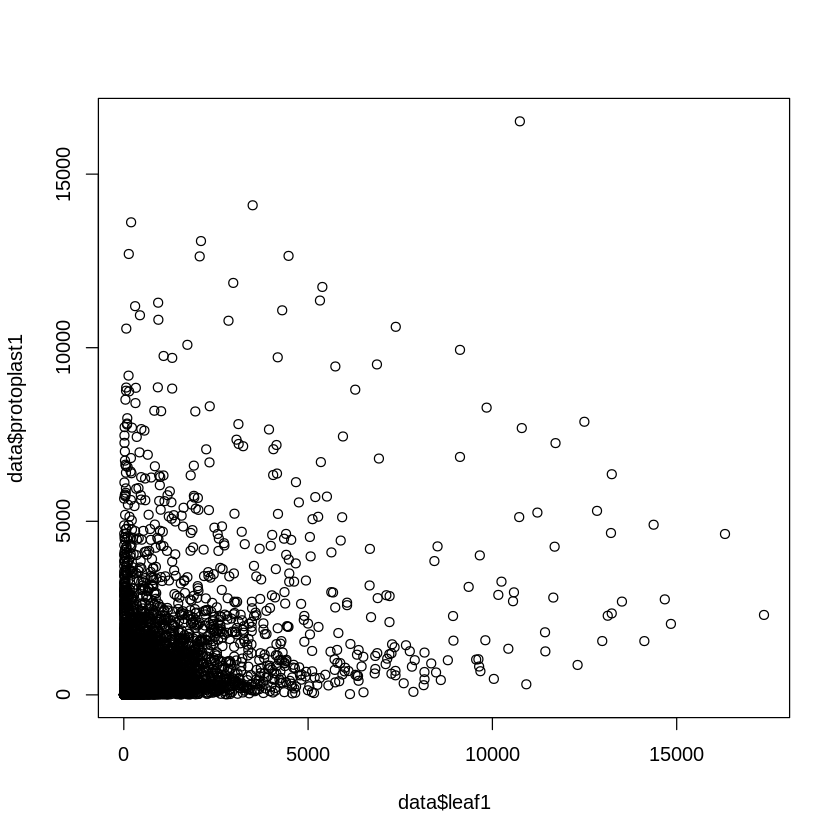

In [6]:
hist(log(data$leaf1))
hist(data$leaf1)
hist(log(data$leaf2))
hist(log(data$protoplast1))
plot(data$leaf1, data$leaf2)
plot(data$leaf1, data$protoplast1)

* わかること
  * ヒストグラムを見るに、同じ形なので処理（=正規化）せずに演算や比較をして良さそう
  *　散布図を見るに、leafどうしだとデータがほぼ一直線上なので誤差は少なそう。
  *　一方で、leafとprotoplastの散布図はデータが散っているのでだいぶ遺伝子発現が変動していそう（個々のデータの分布は似ているが）

### 2つの状態での発現量を比較する
- 左2列のleaf、右2列のprotoplastをそれぞれ2回実験をしたとみなして、誤差を補正するために平均をとることとする。

In [7]:
data$ave_leaf <- rowMeans(data[,1:2])
data$ave_protoplast <- rowMeans(data[,3:4])

例によって実行しても特に何もなかったかのように振る舞いますが、データの中身を見ると行ごとに平均をとった列が増えています。

In [8]:
head(data)

,leaf1,leaf2,protoplast1,protoplast2,ave_leaf,ave_protoplast
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
244901_at,11.91535,9.195704,119.11572,94.60929,10.55553,106.86251
244902_at,26.50220,22.453057,93.52045,87.11625,24.47763,90.31835
244903_at,16.06390,11.471006,131.40715,107.20512,13.76745,119.30614
244904_at,29.37771,38.451554,85.46193,79.22534,33.91463,82.34363
244905_at,12.15569,10.373854,10.88078,12.06227,11.26477,11.47153
244906_at,18.39766,12.265720,324.64969,274.39683,15.33169,299.52326


  - ```data$ave_leaf <- ...``` のようにすることによって、表に1列足す形で結果を追加している。
  - 本当はrowMeansは行列全体で行ごとの和を出すものなので、行列名（データ名）を引数に渡せばいいのだが、今回は2タイプが混じっているのでこのようにしている。
  - [, 1:2] の部分は列番号（この場合、1列目から2列目まで）。もしかして列番号でなくて列名（leaf1など）で指定ができるかもしれないが、見つけきれなかったのでこうしている。

- 同様に計算した平均に対して対数をとる。
- 別に底は2でも10でもいいのだが、マイクロアレイの解析の時は、伝統的に「発現比2倍以上」というデータの絞り込みをしていたため、わかりやすくするために底は2を用いている。（というか、そういうこともわかりやすくするために対数をとるのである）

In [9]:
data$log_leaf <- log2(data$ave_leaf)
data$log_protoplast <- log2(data$ave_protoplast)

- 発現比を計算する。
- **今回やりたいのは、元のデータが何倍の発現量差があるかなので、対数の比をとるのでなく、比をとった後で対数をとる**
  - 覚えていますか：log(A/B) = log(A) - log(B)

In [10]:
data$diff <- data$log_leaf - data$log_protoplast

### 発現量比較のデータを眺めてみる
- diff 列のデータの意味を振り返ってみる
  - `diff = 2` ：log(diff)=2 だから2^2で4倍の発現差がある。この場合、leafの発現が高い
  - `diff = -2`：log(diff)=-2 だから1/(2^2)で1/4倍の発現差がある。この場合、leafの発現が1/4だから、protoplastの方が4倍発現が高い
  - `diff = 0`：log(diff)=0 ということ。つまり、2^0=1。ようするに、leafとprotoplastで発現量が同じということ
- 試しに diff 列について、`max`, `min`, `mean`, `median` を計算してみる

In [11]:
summary(data$diff)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-9.23654 -0.37118  0.01218  0.02161  0.52250  8.20392 

- 特にaverage、medianはほぼ0のはず。（というか、元の分布がそうなるようにすでに補正してあるわけである）
- 実際のデータの分布がどんなかヒストグラムを描いて確認してみる

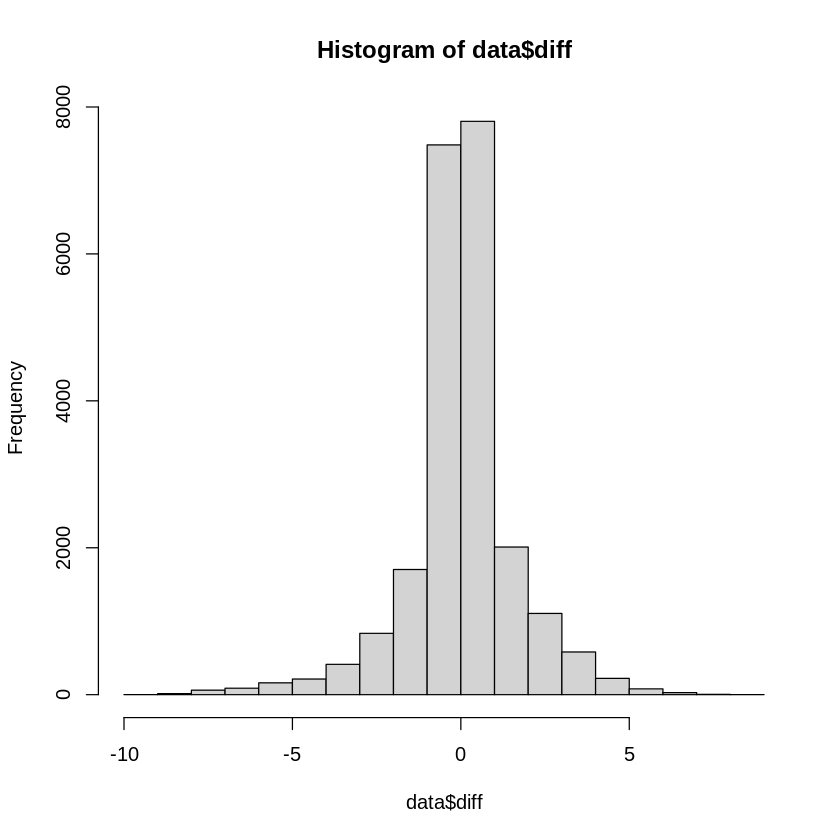

In [12]:
hist(data$diff)

- ちょっとグラフが荒いので、もう少し柱の幅を小さくしてみる

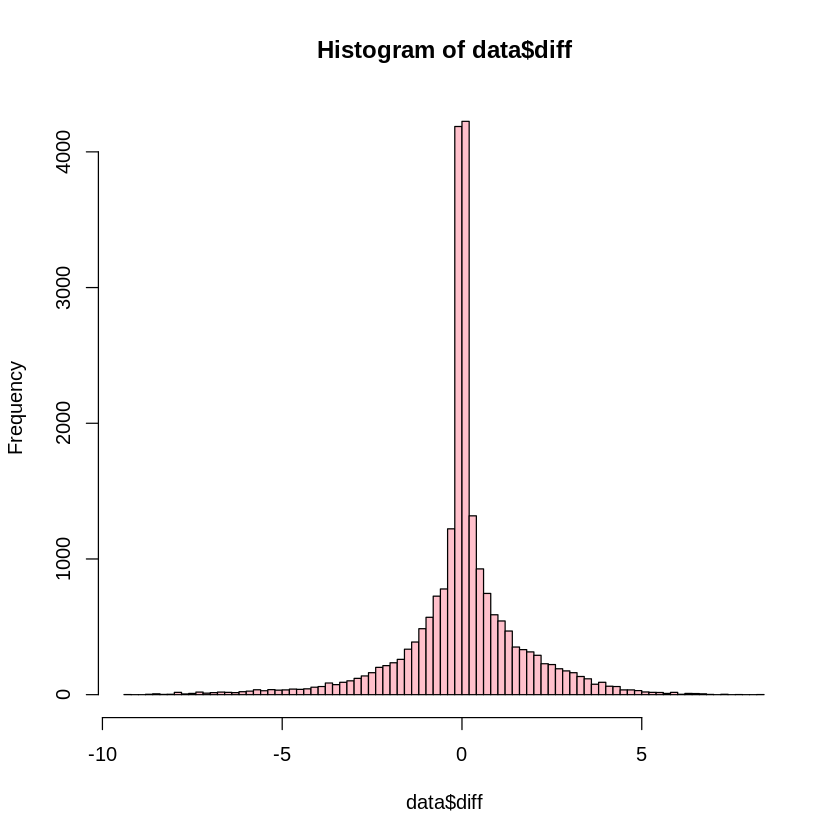

In [13]:
hist(data$diff, breaks = 120, col = "pink")

- hist関数でヒストグラムが描画される
  - 0 を中心に左右対称になっている
  - breaks の数は柱を何本立てるかを指定していると思ってください。
- 実際のデータで分布がどうなっているかも散布図 (scatter plot) で確認することとする

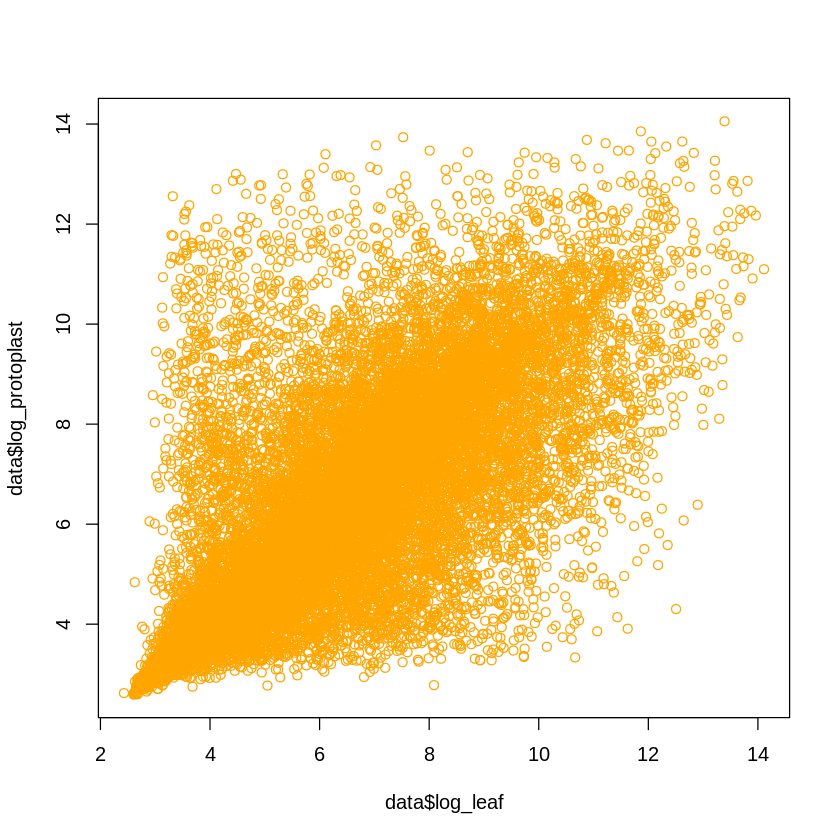

In [14]:
plot(data$log_leaf, data$log_protoplast, col = "orange")

- leafとprotoplastで発現変化がないと、log(leaf)=log(protoplast)、つまりy＝x の上に載りますということ。上のグラフに追加することもできる。


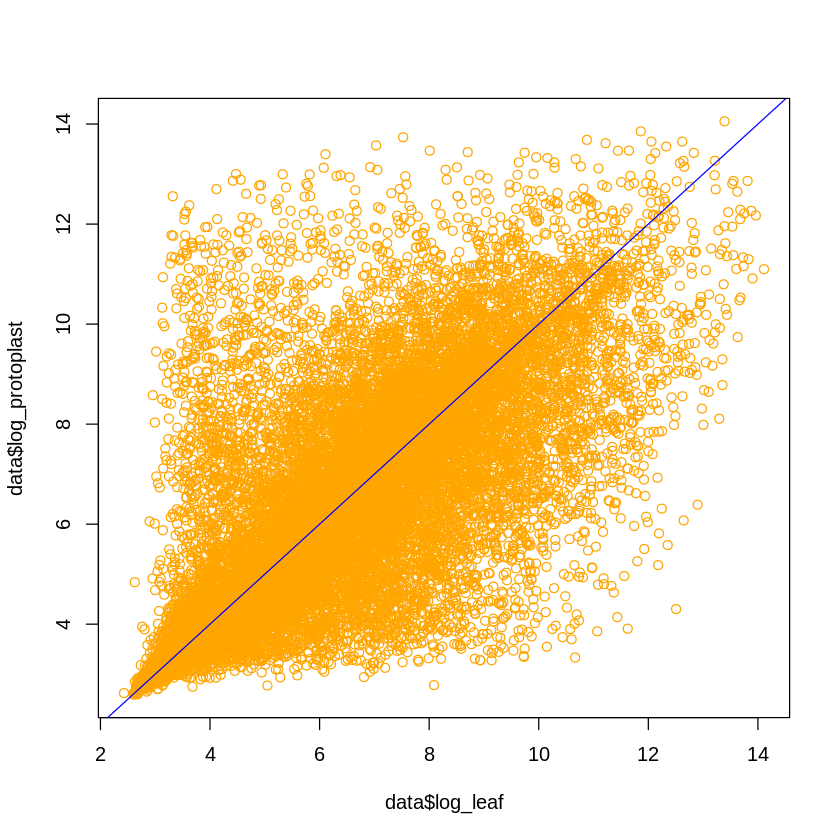

In [15]:
plot(data$log_leaf, data$log_protoplast, col = "orange")
abline(0,1, col = "blue")

- abline(b, a) は、y=ax+b を描画している
  - 普通はablineの中で、add = "T" を記載してグラフを重ね合わせるのだが、中にはablineのように（えてして単純な）グラフは何も指定しないと直前のグラフエリアに描画されるようになっている。
- 散布図 (scatter plot) を眺めてみる
  - 青線から離れるほど、発現が変わっている
  - 下に離れるとleafで発現が大きい、上に離れるとprotoplastで大きい

## 発現に差のある遺伝子の機能解析
- **覚えていますか**：[解析の目標] Arabidopsis（シロイヌナズナ）の葉とプロトプラスト（細胞壁を薬品的に除去した状態）でどんな機能の遺伝子が特異的に（=その状態のみで）働いているか?（または働いていないか?）


### 発現に差のあるデータの絞り込み
- leafで発現の高い遺伝子のみを抽出してみる。今回は試しに8倍以上にしてみる
  - 8 という数字は適当です。
  - 適当というのは、まぁ、こんなもんかな、ってことです。
  - どうしてまぁ、こんなもんかなって思うかは、試しに絞り込んでみて、（全体が20000くらいに対して）いくつくらいに絞り込めるかとか、結果を見てみたらきれいになったとか、信頼度がどのくらいかとか、そういうので決めているだけで、統計的にかっちり基準があるわけではありません。
  - またあとでこのあたりは出てきます
- 今回は8倍以上なのでlog2をとって3以上にしている

In [16]:
data_x3 <- data[data$diff>=3,]
nrow(data_x3)
# head(data_x3)

[1] 915

- nrowで行数をカウントしている。この場合、915行のデータがあるわけだ。
  - ちょっと多いなぁ。。。
  - というわけで、対数で5（実データで32倍）くらいにしてみる
- 対数で5以上にしてみる。

In [17]:
data_x5 <- data[data$diff>=5,]
nrow(data_x5)

[1] 112

- 112個になった。
- 今回はこのくらいで許してやろう

- さきほどの散布図で、対数で5以上の遺伝子の色だけ変えることもできる

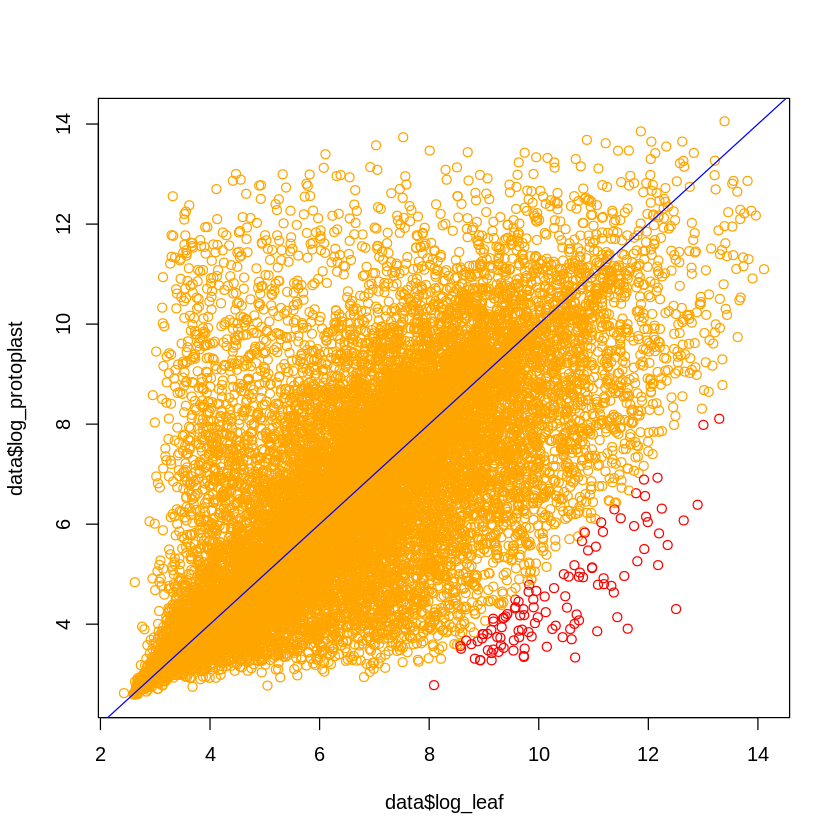

In [18]:
plot(data$log_leaf, data$log_protoplast, col = ifelse(data$diff>=5, "red", "orange"))
abline(0,1, col = "blue")

- 結果をファイルに出力してしまいましょう。

In [19]:
file_rslt <- "GSE15515.up_5.txt"
write(rownames(data_x5), file_rslt)

-　左のファイルリストに出力したファイルが現れます。出てこない場合は、ファイルと書かれた次の行のアイコンのうち真ん中（フォルダーに丸い矢印マーク）をクリックすると出てきます。

## データの生物学的な解釈

-　ここから先は試行錯誤中なのでいろいろ書き換えます。。。(21/6/15)

In [20]:
file_idconv <- "Ath.probe2id.tab"
name_package <- "ath1121501.db"

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c(name_package))
library(name_package, character.only=T)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.15), R 4.1.0 (2021-05-18)

Installing package(s) 'BiocVersion', 'ath1121501.db'

also installing the dependencies ‘bitops’, ‘zlibbioc’, ‘RCurl’, ‘GenomeInfoDbData’, ‘bit’, ‘XVector’, ‘GenomeInfoDb’, ‘bit64’, ‘plogr’, ‘png’, ‘Biostrings’, ‘BiocGenerics’, ‘Biobase’, ‘IRanges’, ‘RSQLite’, ‘S4Vectors’, ‘KEGGREST’, ‘AnnotationDbi’, ‘org.At.tair.db’


Old packages: 'devtools', 'openssl', 'remotes', 'rversions', 'Matrix', 'mgcv'

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clu

In [1]:
#cont <- eval(parse(text=name_package))
#keytypes(cont)
probe_x5 <- rownames(data_x5)
data_x5$geneid <- mget(probe_x5, env=ath1121501ENTREZID)
data_x5$name <- mget(probe_x5, env=ath1121501SYMBOL)

probe_all <- rownames(data)
data$geneid <- mget(probe_all, env=ath1121501ENTREZID)
#param_key <- keys(cont, keytype = "PROBEID")
#data_x5$geneid <- select(cont, keys=param_key, keytype="PROBEID", columns="ENTREZID")
head(data_x5)

ERROR: ignored

In [22]:
BiocManager::install(c("GO.db", "GOstats"))
library("GO.db")
library("GOstats")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.15), R 4.1.0 (2021-05-18)

Installing package(s) 'GO.db', 'GOstats'

also installing the dependencies ‘GSEABase’, ‘genefilter’, ‘XML’, ‘xtable’, ‘Category’, ‘graph’, ‘RBGL’, ‘annotate’, ‘AnnotationForge’, ‘Rgraphviz’


Old packages: 'devtools', 'openssl', 'remotes', 'rversions', 'Matrix', 'mgcv'



Loading required package: Category

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


Loading required package: graph


Attaching package: ‘GOstats’


The following object is masked from ‘package:AnnotationDbi’:

    makeGOGraph




In [23]:
BiocManager::install(c("clusterProfiler", "DOSE"))
library(clusterProfiler)
library(DOSE)
#library(org.Hs.eg.db)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.15), R 4.1.0 (2021-05-18)

Installing package(s) 'clusterProfiler', 'DOSE'

also installing the dependencies ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘RcppArmadillo’, ‘patchwork’, ‘lazyeval’, ‘formatR’, ‘ggforce’, ‘ggrepel’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’, ‘ape’, ‘aplot’, ‘tidytree’, ‘treeio’, ‘lambda.r’, ‘futile.options’, ‘cowplot’, ‘ggraph’, ‘igraph’, ‘scatterpie’, ‘shadowtext’, ‘ggtree’, ‘futile.logger’, ‘snow’, ‘gridExtra’, ‘fastmatch’, ‘downloader’, ‘enrichplot’, ‘GOSemSim’, ‘plyr’, ‘qvalue’, ‘rvcheck’, ‘BiocParallel’, ‘DO.db’, ‘fgsea’, ‘reshape2’


Old packages: 'devtools', 'openssl', 'remotes', 'rversions', 'Matrix', 'mgcv'

clusterProfiler v4.0.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cit

In [24]:
rslt <- enrichGO(gene = data_x5$geneid, ont=BP)